# 1次元問題の差分法シミュレーション

In [ ]:
import numpy as np
import sys
if 'google.colab' in sys.modules:
    print("Installing pygmt on Google Colab. It may take a few minutes.")
    ! pip install -q condacolab &> /dev/null
    import condacolab
    condacolab.install()
    ! mamba install pygmt &> /dev/null
import pygmt

それでは，1次元の運動方程式と構成関係式

$$
\rho \frac{\partial v}{\partial t} = \frac{\partial \sigma}{\partial x}, \quad
\frac{\partial \sigma}{\partial t} = G \frac{\partial v}{\partial x}
$$

をスタガードグリッド差分法で表現してみましょう．ここでは簡単のため，密度$\rho$と剛性率$G$は定数であるとし，速度$v$と応力$\sigma$の変数を，それぞれ時間微分を時間ステップ$\Delta t$の，空間微分を空間グリッド間隔 $\Delta x$の，それぞれ中心差分で離散化していきます．

まずは先の例にならって空間微分を空間差分に置き換えてみましょう．
構成関係式と運動方程式の右辺の微分を差分に書き換えると，それぞれ

$$
\begin{align}
&\frac{\partial \sigma(x,t)}{\partial t} = G \frac{v(x+\Delta x/2,t)-v(x-\Delta x / 2, t)}{\Delta x}
\\
&\rho \frac{\partial v(x,t)}{\partial t} = \frac{\sigma(x+\Delta x/2,t)-\sigma(x-\Delta x / 2, t)}{\Delta x}
\end{align}
$$

と表されそうです．しかし，この組み合わせを直接コンピュータで解こうとすると困ったことがあります．構成関係式のほうに現れる応力 $\sigma$ の位置は $x$，変位速度 $v$の位置は $x\pm \Delta x/2$ なのに対して，運動方程式の位置は 応力が  $x\pm \Delta x/2$，変位速度が $x$ と，あべこべなのです．これでは，$x$と$x\pm \Delta x$における応力と変位速度が両方とも必要になってしまいます．

そこで，構成関係式の位置を全体に $-\Delta x/2$ だけ平行移動してみましょう．そうすると，


$$
\begin{align}
&\frac{\partial \sigma(x-\Delta x/2,t)}{\partial t} = G \frac{v(x,t)-v(x-\Delta x, t)}{\Delta x}
\\
&\rho \frac{\partial v(x,t)}{\partial t} = \frac{\sigma(x+\Delta x/2,t)-\sigma(x-\Delta x / 2, t)}{\Delta x}
\end{align}
$$

となり，位置の対応関係が改善しました．この式では，応力は $x\pm \Delta x/2$の位置だけに，変位速度は$x$と$x+\Delta x$の位置だけに現れます．そのうえで，$x$軸を間隔 $\Delta x$で等間隔に分割し，**グリッド位置** を

$$x_I = x_0 + I \Delta x$$

と定義します．ただし $x_0$ は座標系原点の基準位置，$x_I$ は $I$番目のグリッドにおける位置です．すると，
$$
v(x_I,t) = v_I(t), \quad \sigma(x_I-\Delta x/2, t) = \sigma_{I-1/2}
$$

と表されます．スタガードグリッド差分法では，変数によってグリッド配置が 1/2 分ずれるため，$I$は整数以外に半整数（整数$\pm 1/2$）の値を取りうるのです．これを構成関係式と運動方程式に代入すると，

$$
\begin{align}
	\frac{\partial \sigma_{I-1/2}(t)}{\partial t} = G\frac{v_{I}(t) - v_{I-1}(t) }{\Delta x}
	\\
	\rho \frac{\partial v_I(t)}{\partial t} = \frac{\sigma_{I+1/2}(t)- \sigma_{I-1/2}(t)}{\Delta x}
\end{align}
$$

となります．それぞれの式の左辺のグリッド位置（応力であれば $I-1/2$, 速度であれば $I$ を中心にするように，右辺の空間差分が構成されています．この方程式は任意の$I$について成立しますから，応力と速度それぞれについて等間隔（$\Delta x$）の離散的な位置における方程式が得られたことになります．

続けて，時間微分についても同じように離散化してみます．構成関係式の左辺には応力の時間微分がありますが，応力が時間に対して連続であるという仮定のもと，これを適当な **時間ステップ** 間隔 $\Delta t$ を用いて

$$
\begin{align}
	\frac{\partial \sigma_{I-1/2}(t)}{\partial t} \simeq \frac{\sigma_{I-1/2}(t+\Delta t/2)-\sigma_{I-1/2}(t-\Delta t/2)}{\Delta t}
\end{align}
$$

と近似します．

求めたいのは時刻 $t$ における微分値なので，その時刻を中心とした $t \pm \Delta t/2$ の時刻における $v_i$ を用いて微分値を近似しました．
もとの構成関係式に代入して整理すると，

$$
\begin{align}
	\sigma_{I-1/2}(t+\Delta t/2) = \sigma_{I-1/2}(t-\Delta t/2)
	+ 
	G\frac{v_{I}(t) - v_{I-1} (t) }{\Delta x} \Delta t
\end{align}
$$

と書けます．
この式は，時刻 $t-\Delta t/2$ における同じ位置の応力と時刻 $t$ における $I$, $I+1$ 番目の変位速度から $t+\Delta t/2$ における応力を求める，という，過去から未来を予測するような式になっています．
もしさらに未来のことを求めたければ，$t\rightarrow t+\Delta t$ と全体の時間を1時間ステップだけ進めると，

$$
\begin{align}
	\sigma_i(t+3\Delta t/2) = \sigma_i(t+\Delta t/2)
	+ 
	G\frac{v_{i}(t+\Delta t) - v_{i-1}(t+\Delta t) }{\Delta x} \Delta t
\end{align}
$$

のようになります．地震波の数値シミュレーションは，このように過去の波動の状態から未来の状態を次々と予測することによってなされます．

続けて，変位速度について検討します．
構成関係式の時間についての離散化結果からは，変位速度 $v$ は時刻 $t$, $t+\Delta t$, $t+2\Delta t$, $\cdots$ における値がわかれば良さそうです．
そこで，運動方程式については構成関係式から $\Delta t/2$ だけ時間をずらして，

$$
\begin{align}
	\frac{\partial v_I(t+\Delta t/2)}{\partial t}
	\simeq 
	\frac{v_I(t+\Delta t) - v_I(t)}{\Delta t}
\end{align}
$$

とします．
すると，運動方程式は，

$$
\begin{align}
	v_I(t+\Delta t) = v_I(t) 
	+ 
	\frac{1}{\rho} 
	\frac{\sigma_{I+1/2}(t+\Delta t/2) - \sigma_{I-1/2}(t+\Delta t/2) }{\Delta x} \Delta t
\end{align}
$$

となります．

以上で，構成関係式と運動方程式ついて時間と空間の双方を離散化した式が得られました．
まとめると，

$$
\begin{align}
	 &	\sigma_{I-1/2}(t+\Delta t/2) = \sigma_{I-1/2}(t-\Delta t/2)
	 + 
	 G\frac{v_{I}(t) - v_{I-1} (t) }{\Delta x} \Delta t 
	\\
	 & v_I(t+\Delta t) = v_I(t) 
	 + 
	 \frac{1}{\rho} 
	 \frac{\sigma_{I+1/2}(t+\Delta t/2) - \sigma_{I-1/2}(t+\Delta t/2) }{\Delta x} \Delta t
\end{align}
$$

の2式です．

応力と変位速度の離散化された時刻が互いに $\Delta t/2$ だけずれていて，かつ両辺とも右辺の値が左辺よりも過去の情報だけで記述されています．しかも，構成関係式によって，あらゆる $I$ について応力 $\sigma_{I-1/2}(t+\Delta t/2)$ を求めておけば，それが運動方程式の右辺に使えます．すなわち，これらの式を交互に使うことで，変位速度と応力の時間発展を追跡できるのです．


## グリッド変数の置き換え

これでスタガードグリッド差分法の核となるアルゴリズムの導出はほとんど終わりなのですが，この結果をそのままコンピュータプログラムに落とし込もうとすると，$I \pm 1/2 $の半整数のグリッド位置の扱いが厄介です．多くのプログラミング言語では，たとえば `v[1], v[2], .... ` のように一つの変数名 `v` に複数の値を割り当てる，配列あるいはリストといった概念がありますが，ほとんどの場合その引数は整数のみです．

そこで，このような半整数のグリッド位置を扱うために，グリッド位置を整数のみで表現する置き換えを考えます．

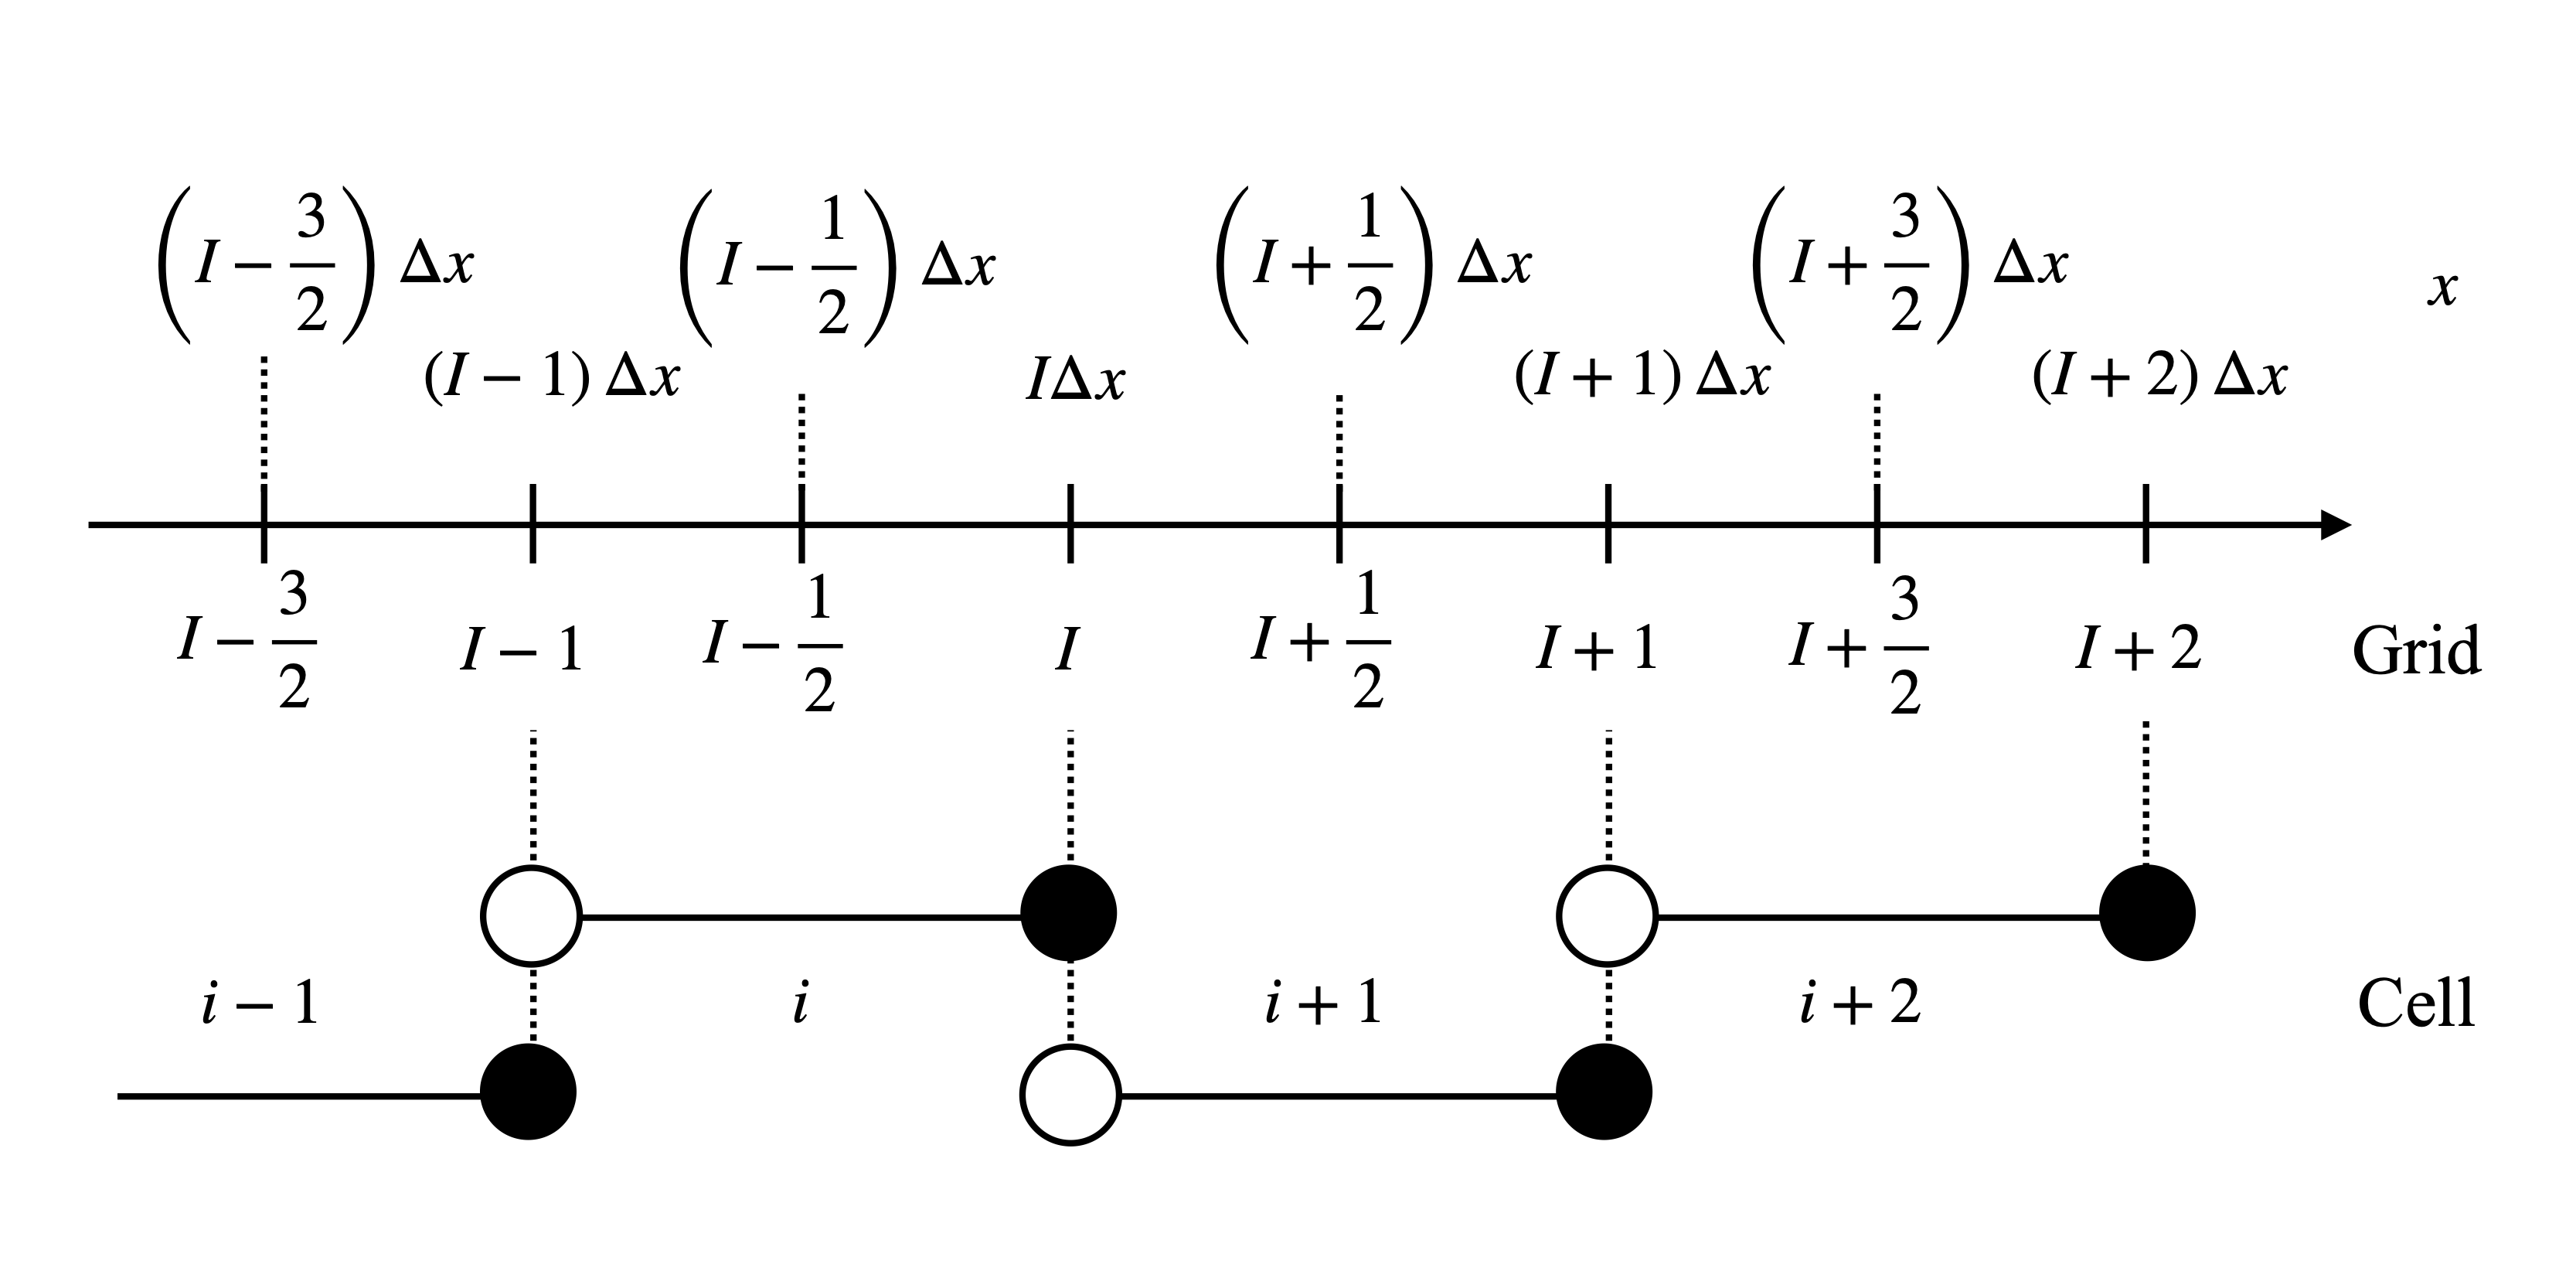

そこで，グリッド番号$I$に対して，

$$
(I-1) \Delta x < x  \le I \Delta x
$$

の範囲を $i$ 番目の **セル** と定義します（上図）．大文字の $I$ がグリッド，小文字の $i$ はセルとして区別します．そうすると，グリッド番号 $I-1/2$ は $i$番目のセルに，$I+1/2$ は $i+1$ 番目のセルに属するわけですから，先の差分法アルゴリズムは，セル番号を用いて

$$
\begin{align}
	 &	\sigma_i(t+\Delta t/2) = \sigma_i(t-\Delta t/2)
	 + 
	 G\frac{v_i(t) - v_{i-1} (t) }{\Delta x} \Delta t 
	\\
	 & v_i(t+\Delta t) = v_i(t) 
	 + 
	 \frac{1}{\rho} 
	 \frac{\sigma_{i+1}(t+\Delta t/2) - \sigma_{i-1}(t+\Delta t/2) }{\Delta x} \Delta t
\end{align}
$$

と，整数のセル番号のみを用いて書き下すことができました．

さらにもうひと工夫します．上式の差分法のアルゴリズムでは，右辺が過去，左辺が未来の値を表しています．たとえば応力$\sigma$に着目してみると，$t-\Delta t/2$における $\sigma$ の値がわかれば，$t+\Delta t/2$における値に**アップデート**できます．そして，一度アップデートしたら，$t-\Delta t/2$ の過去の値が参照されることはもうありません．

ということは，過去の値を保存しておく必要がないのです．そこで，過去の値を保存するための変数を導入せず，上書きしてしまえるのです．

### 実践 1次元地震波数値シミュレーション

では，いきなりですが，ここまでで得られたアルゴリズムを踏まえて数値シミュレーションを実施してみましょう．

In [ ]:
dx = 0.2               # 空間グリッドサイズ (km)
dt = 0.05              # 時間ステップサイズ (s)
nx = 1001              # 空間グリッド数
nt = 401               # 時間ステップ数
L  = 8.0               # 初期条件の波長 (km)

V   = np.zeros(nx+1)   # 変位速度
S   = np.zeros(nx+2)   # 応力
rho = np.zeros(nx+1)   # 質量密度
G   = np.zeros(nx+1)   # 弾性係数

# 媒質の設定
beta   = 4.0               # 仮定する地震波速度 (km/s)
rho[:] = 2.7               # 仮定する質量密度 (g/cm^3)
G[:]   = rho * beta * beta # 剛性率 G = ρ x β^2

# 初期条件
hw = int(L/2/dx + 0.5)
for i in range(-hw, hw+1):
    V[int((nx - 1)/2)+1+i] = np.cos(np.pi/2.0*i/hw)**2

# 結果出力ファイルの準備と初期状態の出力
n = 0
fp = open('out.dat', 'w')
for i in range(1, nx+1):
    print(f"{(i-1)*dx:12.4e} {n*dt:12.4e} {V[i]:12.4e} {S[i]:12.4e}", 
          file=fp)

# 時間発展
for n in range(1, nt+1):
   
    # 構成関係式
    for i in range(1, nx+1):
        dxV = ( V[i] - V[i-1] ) / dx
        S[i] += G[i] * dxV * dt

    # 運動方程式
    for i in range(1, nx+1):
        dxS = ( S[i+1] - S[i] ) / dx
        V[i] += dxS / rho[i] * dt

    # データ出力
    for i in range(1, nx+1):
        print(f"{(i-1)*dx:12.4e} {n*dt:12.4e} {V[i]:12.4e} {S[i]:12.4e}", 
              file=fp)
    
fp.close()

コメントに「時間発展」とか書かれているところから先が差分法による数値シミュレーションのメイン部分です．数式通りに，まず右辺の空間微分を差分近似で評価し，時間差分を整理した結果をつかって左辺の値をアップーデートする，という流れで計算が進んでいることがわかるでしょうか．

上記コードを実行すると，`out.dat` というファイルが作られます．その中身の一部を取り出してみると，

```
  4.8200e+01   1.2800e+01   4.8168e-01   5.0092e+00
  4.8400e+01   1.2800e+01   4.9384e-01   5.2022e+00
  4.8600e+01   1.2800e+01   5.0000e-01   5.3335e+00
  4.8800e+01   1.2800e+01   5.0000e-01   5.4000e+00
  4.9000e+01   1.2800e+01   4.9384e-01   5.4000e+00
  4.9200e+01   1.2800e+01   4.8168e-01   5.3335e+00
```

のように4列からなるデータです．このデータは，左2列から位置 `x`, 時刻 `t`で，その位置と時間における変位速度 `V`, 応力 `S` の変数が3列目と4列目に格納されています．つまりこのデータ一つで，地震波の時間・空間両方の広がりが記述されていることになります．

いま興味があるのは位置・時間と変位速度ですので，結果ファイルからこれらを取り出します．

In [ ]:
d = np.loadtxt('out.dat') # 1行ずつのリストの集合体として読み込まれる
xx, tt, VV, _  = d.T      # 転置 `.T` により1列ごとのデータに変換する

このデータを可視化してみます．各地点における地震波形のレコードセクションを作成してみましょう．

In [ ]:
def wvplot_record(xx, tt, VV): 
    """シミュレーション結果のレコードセクション表示"""

    scale = 25
    
    fig = pygmt.Figure()

    fig.basemap(projection='X12c/8c', region=[0, 20, 0, 200], 
                frame = ['WS', 'xaf+ltime [s]', 'yaf+ldistance [km]'])
    
    for x in np.arange(0, 200, 2):

        # 位置 xx がループ変数 x に十分に近いところの時間・変位速度を取り出す
        mask = np.where(np.isclose(xx, x))
        ttt = tt[mask]
        VVV = VV[mask]

        # y軸位置を距離分だけずらしてプロットする
        fig.plot(x=ttt, y=x+VVV*scale, pen='thinner,black@50')

    return fig

In [ ]:
wvplot_record(xx, tt, VV)

続けて，振幅分布のアニメーションです．以下の関数 `wvplot_anim` は，時刻 0 から 20秒まで，0.2秒ずつの振幅分布をすべて作成します．それをパラパラマンガとして動画化してくれるのが，その次の `gif_movie` 関数です．

In [ ]:
def wvplot_anim(xx, tt, VV): 

    figs = []

    for t in np.arange(0, 20, 0.2):

        fig = pygmt.Figure()
        with pygmt.config(MAP_GRID_PEN_PRIMARY = '0.25p,30/30/30,.'): 
            fig.basemap(projection='X12c/6c', region=[0, 200, -0.1, 1.1], 
                        frame = ['WS', 
                                 'xafg+ldistance [km]', 
                                 'yafg+lvelocity amplitude'])
        mask = np.where(np.isclose(tt, t))
        xxx = xx[mask]
        VVV = VV[mask]
    
        fig.plot(x=xxx, y=VVV, pen='thicker,150/100/250')
        fig.text(x=198, y = 0.98, justify='RT', text=f"t = {t:5.1f} s", 
                 font='12p,Helvetica,Black')
        figs.append(fig)

    return figs

In [ ]:
def gif_movie(figs, dpi=720, crop='0.5c'): 
    
    """
    PyGMTのFigureオブジェクトのリストからGifアニメーションを作成する．Jupyter Notebook上で表示されるオブジェクトを返す．

    Parameters
    ----------
    figs : list of Figure
        PyGMTのFigureオブジェクトのリスト
    dpi : int, optional
        解像度 (default: 720)
    crop : str, optional
        余白のトリミング量 (default: '0.5c')

    Returns
    -------
    HTML : IPython.display.HTML
        Gifアニメーション
    """
    from IPython import display as dd
    import tempfile
    import base64
    import os
    
    with tempfile.TemporaryDirectory() as tmpdir:
        for i, fig in enumerate(figs):
            figname = f'plot_{i:05d}.png'
            print(f'\rsaving figs ... ({(i+1)/len(figs)*100:5.1f}%)', end='')
            fig.savefig(os.path.join(tmpdir, figname), dpi=dpi, crop=crop)
        print(' Done.')
        
        cmd1 = f'ffmpeg -i {tmpdir}/plot_%5d.png '
        cmd2 = f' -vf "scale=800:-1,split [a][b];[a] palettegen [p];[b][p] paletteuse" '
        cmd3 = f' {tmpdir}/out.gif > /dev/null 2>&1'
        print(f'making gif ... ', end='')
        os.system(cmd1 + cmd2 + cmd3)
        print(' Done.')
        
        with open(f'{tmpdir}/out.gif', 'rb') as f:
            b64 = base64.b64encode(f.read()).decode("ascii")
        
    return dd.HTML(f'<img src="data:image/gif;base64,{b64}" width="80%"/>')

In [ ]:
ff = wvplot_anim(xx, tt, VV)

In [ ]:
gif_movie(ff) #1分くらいかかります．辛抱強く待ちましょう．

これで一通りの1次元地震波伝播シミュレーションが出来上がりました．このシミュレーションは，`beta` や `rho` のパラメタを変えるだけで，不均質な媒質中の地震波伝播を再現できます．実際にパラメタを変えて，色々試してみましょう．